# Problem

- states : Two locations (1, 2), maximum of 20 cars of each

$$ s_1 \in [0, 20] $$
$$ s_2 \in [0, 20] $$

- Actions : Move up to 5 cars between locations overnight

$$ a \in \{-5, -4, -3, ..., 0, 1, 2, 3, 4 , 5\}$$

- Reward : `$10` for each car rented (must be available), `-$2` for each car moved 

$$R_t = 10 \times (\text{satisfied_requests}) -2 \times (\text{moved})$$

- Transitions : Cars returned and requested rondomly
    - p(s',r | s, a)

$$P_{S_1 S_2}^{return} = \frac{\lambda^{n}}{n!}e^{-\lambda}$$

$$P_{S_2 S_1}^{return} = \frac{\lambda^{n}}{n!}e^{-\lambda}$$

$$P_{S_1 S_2}^{request} = \frac{\lambda^{n}}{n!}e^{-\lambda}$$

$$P_{S_2 S_1}^{request} = \frac{\lambda^{n}}{n!}e^{-\lambda}$$

In [151]:
from scipy.stats import poisson
import seaborn as sns

data_possion = poisson.rvs(mu=3, size=50)
data_possion

array([2, 0, 3, 3, 2, 2, 0, 2, 1, 1, 7, 3, 0, 6, 1, 5, 2, 4, 5, 2, 3, 2,
       1, 3, 3, 2, 2, 4, 1, 3, 1, 2, 2, 3, 1, 2, 1, 1, 3, 3, 1, 5, 5, 4,
       1, 1, 2, 3, 2, 2])

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Possion Distribution')]

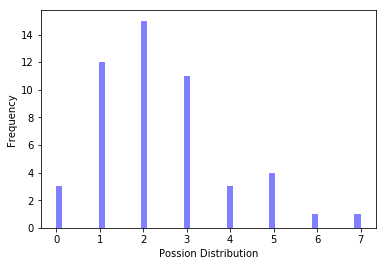

In [225]:
ax = sns.distplot(data_possion,
                  bins = 50,
                  kde = False,
                  color = 'blue',
                  hist_kws = {'linewidth':1, 'alpha':0.5})
ax.set(xlabel='Possion Distribution', ylabel='Frequency')

## 1. state, discount rate, reward 을 설정하기 위한 정보 (문제)

In [324]:
import numpy as np
import sys
import matplotlib.pyplot as plt

class JacksCarsRental:
    
    @staticmethod
    def max_cars():
        return 20
    
    # discount_rate
    @staticmethod    
    def discount_rate():
        return 0.9
    
    # reward
    @staticmethod    
    def credit_reward():
        return 10
    
    @staticmethod
    def moving_reward():
        return -2

## 2. transition probability

In [325]:
from scipy.stats import poisson

class poisson_:
    
    def __init__(self, mu):
        self.mu = mu
        
        epsilon = 0.01
        
        # [alpha , beta] is the range of n's for which the pmf value is above epsilon
        self.alpha = 0
        self.beta = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.alpha, self.mu) 
                if(temp <= epsilon):
                    self.alpha += 1
                else:
                    self.vals[self.alpha] = temp
                    summer += temp
                    self.beta = self.alpha+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.beta, self.mu)
                if(temp > epsilon):
                    self.vals[self.beta] = temp
                    summer += temp
                    self.beta+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [alpha, beta] have pmf = 0
        added_val = (1-summer)/(self.beta-self.alpha)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

### location 및 action에 따른 transition probability 설정

In [367]:
# A class holding the properties of a location together
# location 및 action에 따른 transition probability 설정
class location:
    
    def __init__(self, requests, returns):
        self.alpha = requests                     # value of lambda for requests
        self.beta = returns                       # value of lambda for returns
        self.poisson_alpha = poisson_(self.alpha)
        self.poisson_beta = poisson_(self.beta)

# Location 초기화
first_location = location(requests=3, returns=3)
second_location = location(requests=4, returns=2)

## 3. state table, policy table 초기화

In [327]:
# Initializing the value and policy matrices. 
# Initial policy has zero value for all states.

value = np.zeros((JacksCarsRental.max_cars()+1, JacksCarsRental.max_cars()+1))
policy = value.copy().astype(int)

print(value.shape)
print(policy.shape)

(21, 21)
(21, 21)


In [328]:
first_location.poisson_alpha.vals

{0: 0.05127513134990861,
 1: 0.15084926808563653,
 2: 0.2255298706374324,
 3: 0.2255298706374324,
 4: 0.1695194187235855,
 5: 0.10230687642696924,
 6: 0.051897469704506906,
 7: 0.023092094434528487}

In [329]:
first_location.poisson_beta.vals

{0: 0.05127513134990861,
 1: 0.15084926808563653,
 2: 0.2255298706374324,
 3: 0.2255298706374324,
 4: 0.1695194187235855,
 5: 0.10230687642696924,
 6: 0.051897469704506906,
 7: 0.023092094434528487}

In [368]:
print(first_location.poisson_alpha.alpha)
print(first_location.poisson_alpha.beta)
print(first_location.poisson_beta.alpha)
print(first_location.poisson_beta.beta)

0
8
0
8


In [369]:
print(second_location.poisson_alpha.alpha)
print(second_location.poisson_alpha.beta)
print(second_location.poisson_beta.alpha)
print(second_location.poisson_beta.beta)

0
10
0
7


## 4. Policy iteration 

<img src="https://miro.medium.com/max/1094/1*ZYq8bX-q4Z8-8aPndQaz9w.png">

### Policy evaluation

#### Expected reward 

In [332]:
def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """
    
    # expected_reward 초기화
    expected_reward = 0
    
    new_state = [max(min(state[0] - action, JacksCarsRental.max_cars()),0) , 
                 max(min(state[1] + action, JacksCarsRental.max_cars()),0)]
    
    # adding reward for moving cars from one location to another (which is negative) 
    
    expected_reward = expected_reward + JacksCarsRental.moving_reward() * abs(action)
    
    # there are four discrete random variables which determine the probability distribution of the reward and next state
    for first_requests in range(first_location.poisson_alpha.alpha, first_location.poisson_alpha.beta):
        for second_requests in range(second_location.poisson_alpha.alpha, second_location.poisson_alpha.beta):
            for first_returns in range(first_location.poisson_beta.alpha, first_location.poisson_beta.beta):
                for second_returns in range(second_location.poisson_beta.alpha, second_location.poisson_beta.beta):
                    """
                    first_requests  : sample of cars requested at first_location
                    second_requests : sample of cars requested at second_location
                    first_returns   : sample of cars returned at first_location 
                    second_returns  : sample of cars returned at second_location 
                    prob : probability of this event happening
                    """

                    # all four variables are independent of each other
                    prob = first_location.poisson_alpha.vals[first_requests] * second_location.poisson_alpha.vals[second_requests] * first_location.poisson_beta.vals[first_returns] * second_location.poisson_beta.vals[second_returns]
                    
                    valid_requests_A = min(new_state[0], first_requests)
                    valid_requests_B = min(new_state[1], second_requests)

                    reward = (valid_requests_A + valid_requests_B)*(JacksCarsRental.credit_reward())

                    # calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + first_requests, JacksCarsRental.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + second_requests, JacksCarsRental.max_cars()),0)

                    # Bellman's equation
                    expected_reward += prob * (reward + JacksCarsRental.discount_rate() * value[new_s[0]][new_s[1]])

    return expected_reward

In [333]:
def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    epsilon = policy_evaluation.epsilon
    
    policy_evaluation.epsilon /= 10 
    
    while(1):
        k = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                k = max(k, abs(value[i][j] - old_val))
                
                print('.', end = '')
                sys.stdout.flush()
        print(k)
        sys.stdout.flush()
    
        if k < epsilon:
            break

#initial value of ε
policy_evaluation.epsilon = 50

In [334]:
expected_reward

<function __main__.expected_reward(state, action)>

### Policy improvement

In [335]:
def policy_improvement():
    # policy table을 전역변수로 관리 
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            car_capacity_12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            car_capacity_21 = - min(j,5)     # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(car_capacity_21,car_capacity_12+1):
                temp_expected_reward = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = temp_expected_reward
                    max_act = act
                elif max_act_val < temp_expected_reward:
                    max_act_val = temp_expected_reward
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable

In [336]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.close()

In [340]:
save_policy.counter = 0
save_value.counter = 0

In [341]:
# k = 1
policy_evaluation()

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................146.2040837604319
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................39.21418143680148
..................................................................................

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................6.787318282880847
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................6.108586454589499
..................................................................................

In [ ]:
# k = 2
policy_evaluation()

## Discussion

Text(33.0, 0.5, '#Cars at first location')

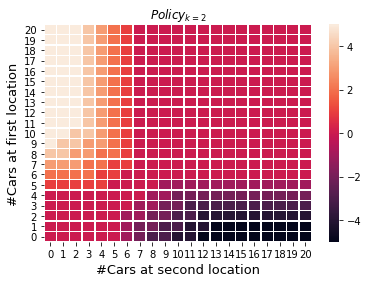

In [375]:
ax = sns.heatmap(policy, linewidth=0.5)
ax.invert_yaxis()
plt.title("$Policy_{k=2}$")
plt.xlabel('#Cars at second location', fontsize=13)
plt.ylabel('#Cars at first location', fontsize=13)

> 위 figure는 $\pi_{k = 2}$인 경우, 각 state에서의 policy(action)를 시각화  
> 
> 각각의 `first location`, `second location`의 state가 gird로 표현되어있으며, cell 색상이 의미하는 것은 각 state에서의 action에 해당되는 action을 의미합니다.

Text(33.0, 0.5, '#Cars at first location')

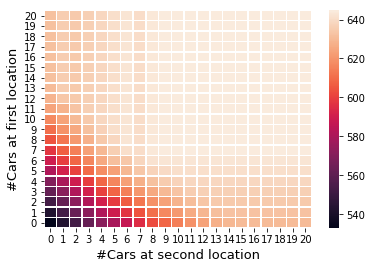

In [371]:
ax = sns.heatmap(value, linewidth=0.5)
ax.invert_yaxis()
plt.xlabel('#Cars at second location', fontsize=13)
plt.ylabel('#Cars at first location', fontsize=13)

> 위 figure는 $\pi_{k = \infty}$인 경우, 각 state에서의 value를 시각화  
> 
> 각각의 `first location`, `second location`의 state가 gird로 표현되어있으며, cell 색상이 의미하는 것은 state에서의 value를 의미합니다.